In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import os
from tqdm import tqdm
from scipy.optimize import fsolve

In [2]:
def getTTFT(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    itl=[]
    rps=[]
    # print(data['benchmarks'][0]['metrics'].keys())
    for i in range(len(data)):
        # print(data['benchmarks'][i]['metrics'].keys())
        itl.append(data[i]['time_to_first_token_ms']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    itl, rps=np.array(itl), np.array(rps)
    # print(itl)
    # print(rps)
    indx=np.argsort(rps)

    return  rps[indx],itl[indx]

def getITL(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    itl=[]
    rps=[]
    # print(data['benchmarks'][0]['metrics'].keys())
    for i in range(len(data)):
        # print(data['benchmarks'][i]['metrics'].keys())
        itl.append(data[i]['inter_token_latency_ms']['successful']['mean'])
        #rps.append((data[i]['requests_per_second']['successful']['mean']))
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    # print(itl)
    # print(rps)
    indx=np.argsort(rps)
    itl = itl[indx]
    rps = rps[indx]

    return  rps,itl

def getRequestLatency(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    itl=[]
    rps=[]

    # print(data['benchmarks'][0]['metrics'].keys())
    for i in range(len(data)):
        # print(data['benchmarks'][i]['metrics']['request_latency']['successful'].keys())
        itl.append(data[i]['request_latency']['successful']['mean'] * 1000)
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    itl, rps=np.array(itl), np.array(rps)
    indx=np.argsort(rps)
    itl = itl[indx]
    rps = rps[indx]
    itl = itl[:-4]
    rps = rps[:-4]
    return  rps, itl

def getTPOT(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    itl=[]
    rps=[]
    # print(data['benchmarks'][0]['metrics'].keys())
    for i in range(len(data)):
        # print(data['benchmarks'][i]['metrics'].keys())
        itl.append(data[i]['time_per_output_token_ms']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    itl, rps=np.array(itl), np.array(rps)
    # print(itl)
    # print(rps)
    indx=np.argsort(rps)

    return  rps[indx],itl[indx]


In [3]:
def expected_acceptance_length(alpha, draft):
    if alpha == 1.0:
        return draft + 1
    else:
        return (1. - alpha ** (draft + 1)) / (1. - alpha)

In [4]:
def fit_ITL_from_RPS(rps, lat, Et, k, label=None, debug=False):
    def model(x, b1 , b2, c1, c2, d1, d2, f1, f2):
        return (b1 + b2*k + (c1 + c2*k)/Et) / (1 - (d1 + d2*k + (f1 + f2*k)/Et) * x)
    def fit_model(x, b1, b2, c1, c2, d1, d2, f1, f2):
        rps, lat = x
        return model(rps, b1, b2, c1, c2, d1, d2, f1, f2) / lat
    A = np.vstack([np.ones_like(rps)/lat, k/lat, np.ones_like(rps)/Et/lat, k/Et/lat, rps, rps*k, rps/Et, rps*k/Et]).T
    z = np.ones_like(rps)
    b1_0, b2_0, c1_0, c2_0, d1_0, d2_0, f1_0, f2_0 = np.linalg.lstsq(A, z, rcond=None)[0]   # z ≈ a + b x
    
    # Set bounds to ensure all parameters are non-negative
    # Lower bounds: all parameters >= 0
    lower_bounds = [0, 0, 0, 0, 0, 0, 0, 0]
    # Upper bounds: no upper limit (use np.inf)
    upper_bounds = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
    bounds = (lower_bounds, upper_bounds)
    
    #popt, pcov = curve_fit(model, baseline_rps, baseline_itl, p0=[c1_0, c2_0], maxfev=10000)
    popt, pcov = curve_fit(fit_model, (rps, lat), np.ones_like(rps), 
                          p0=[b1_0, b2_0, c1_0, c2_0, d1_0, d2_0, f1_0, f2_0], 
                          bounds=bounds, maxfev=10000)
    #popt = [b1_0, b2_0, c1_0, c2_0, d1_0, d2_0, f1_0, f2_0]
    #popt = [c1_0, c2_0, d1_0, d2_0, f1_0, f2_0]
    # plt plot the data and fit and return the fit parameters
    if debug:
        plt.scatter(rps, lat, label='Request Latency', color='blue')
        plt.xlabel("RPS")
        plt.ylabel("Latency")
        if label is not None:
            plt.title(f"Modeled vs Measured Latency, {label}")
        else:
            plt.title("Modeled vs Measured Latency")
        plt.plot(rps, model(rps, *popt), label='Modeled Latency', color='red')
        plt.legend()

        # Add the popt parameters to the plot in the form of the formula
        plt.text(0.05, 0.95, f'ITL = {popt[0]:.2f} / (1 - {popt[1]:.2f} * RPS)', 
                transform=plt.gca().transAxes, verticalalignment='top',
                color='black')
        
        plt.show()
    return popt

In [5]:
model_sizes = ["0.6B", "1.7B", "4B", "8B", "14B", "32B"]

alphas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
drafts = [1, 2, 3, 4, 5, 6, 8, 10]

prefill_decode_combinations = [
    (1024, 1024),
    (256, 1024),
    (256, 128),
    (512, 128),
    (512, 256),
    (768, 128),
    (1024, 128),
]

DATA_DIR = "/proving-grounds/machine/linghao/speculators/throughput-reduced/"

In [ ]:
# model_sizes = ["4B"]
# alphas = [0.8]
# drafts = [5]





all_b1 = np.zeros((len(model_sizes), len(alphas), len(drafts), len(prefill_decode_combinations)))
all_b2 = np.zeros((len(model_sizes), len(alphas), len(drafts), len(prefill_decode_combinations)))
all_c1 = np.zeros((len(model_sizes), len(alphas), len(drafts), len(prefill_decode_combinations)))
all_c2 = np.zeros((len(model_sizes), len(alphas), len(drafts), len(prefill_decode_combinations)))
all_d1 = np.zeros((len(model_sizes), len(alphas), len(drafts), len(prefill_decode_combinations)))
all_d2 = np.zeros((len(model_sizes), len(alphas), len(drafts), len(prefill_decode_combinations)))
all_f1 = np.zeros((len(model_sizes), len(alphas), len(drafts), len(prefill_decode_combinations)))
all_f2 = np.zeros((len(model_sizes), len(alphas), len(drafts), len(prefill_decode_combinations)))


all_b1[:] = np.nan
all_b2[:] = np.nan
all_c1[:] = np.nan
all_c2[:] = np.nan
all_d1[:] = np.nan
all_d2[:] = np.nan
all_f1[:] = np.nan
all_f2[:] = np.nan
for i, model_size in tqdm(enumerate(model_sizes), total=len(model_sizes)):
    for j, alpha in enumerate(alphas):
        for k, draft in enumerate(drafts):
            for l, (prefill, decode) in enumerate(prefill_decode_combinations):
                try:
                    path = f"{DATA_DIR}/output_Qwen3-{model_size}_FS_alpha-{alpha:.2f}_draft-{draft}_prompt-{prefill}_output-{decode}_concurrency-128_reduced.json"
                    rps_, lat_ = getRequestLatency(path)
                    Et_ = expected_acceptance_length(alpha, draft)
                    Et_ = np.ones_like(rps_) * Et_
                    k_ = np.ones_like(rps_) * draft
                    fit = fit_ITL_from_RPS(rps_, lat_, Et_, k_, f"Alpha: {alpha}, Draft: {draft}, Prefill: {prefill}, Decode: {decode}", debug=False)
                    all_b1[i, j, k, l] = fit[0]
                    all_b2[i, j, k, l] = fit[1]
                    all_c1[i, j, k, l] = fit[2]
                    all_c2[i, j, k, l] = fit[3]
                    all_d1[i, j, k, l] = fit[4]
                    all_d2[i, j, k, l] = fit[5]
                    all_f1[i, j, k, l] = fit[6]
                    all_f2[i, j, k, l] = fit[7]
                except Exception as e:
                    print(f"Error fitting ITL for {path}: {e}")
                    all_b1[i, j, k, l] = np.nan
                    all_b2[i, j, k, l] = np.nan
                    all_c1[i, j, k, l] = np.nan
                    all_c2[i, j, k, l] = np.nan
                    all_d1[i, j, k, l] = np.nan
                    all_d2[i, j, k, l] = np.nan
                    all_f1[i, j, k, l] = np.nan
                    all_f2[i, j, k, l] = np.nan

 50%|█████     | 3/6 [00:52<00:51, 17.29s/it]/tmp/ipykernel_1020089/1395954620.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fit_model, (rps, lat), np.ones_like(rps),


Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-8B_FS_alpha-0.50_draft-6_prompt-1024_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-8B_FS_alpha-0.50_draft-6_prompt-1024_output-1024_concurrency-128_reduced.json'
Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-8B_FS_alpha-0.50_draft-8_prompt-1024_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-8B_FS_alpha-0.50_draft-8_prompt-1024_output-1024_concurrency-128_reduced.json'
Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-8B_FS_alpha-0.50_draft-10_prompt-1024_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/s

 67%|██████▋   | 4/6 [01:09<00:34, 17.25s/it]

Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-14B_FS_alpha-0.50_draft-1_prompt-1024_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-14B_FS_alpha-0.50_draft-1_prompt-1024_output-1024_concurrency-128_reduced.json'
Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-14B_FS_alpha-0.50_draft-2_prompt-1024_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-14B_FS_alpha-0.50_draft-2_prompt-1024_output-1024_concurrency-128_reduced.json'
Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-14B_FS_alpha-0.50_draft-3_prompt-1024_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/lingh

 83%|████████▎ | 5/6 [01:22<00:15, 15.73s/it]

Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-32B_FS_alpha-0.50_draft-1_prompt-1024_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-32B_FS_alpha-0.50_draft-1_prompt-1024_output-1024_concurrency-128_reduced.json'
Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-32B_FS_alpha-0.50_draft-1_prompt-256_output-1024_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-32B_FS_alpha-0.50_draft-1_prompt-256_output-1024_concurrency-128_reduced.json'
Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-32B_FS_alpha-0.50_draft-1_prompt-256_output-128_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/s

100%|██████████| 6/6 [01:26<00:00, 14.34s/it]

Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-32B_FS_alpha-1.00_draft-4_prompt-512_output-256_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-32B_FS_alpha-1.00_draft-4_prompt-512_output-256_concurrency-128_reduced.json'
Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-32B_FS_alpha-1.00_draft-4_prompt-768_output-128_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-32B_FS_alpha-1.00_draft-4_prompt-768_output-128_concurrency-128_reduced.json'
Error fitting ITL for /proving-grounds/machine/linghao/speculators/throughput-reduced//output_Qwen3-32B_FS_alpha-1.00_draft-4_prompt-1024_output-128_concurrency-128_reduced.json: [Errno 2] No such file or directory: '/proving-grounds/machine/linghao/specul

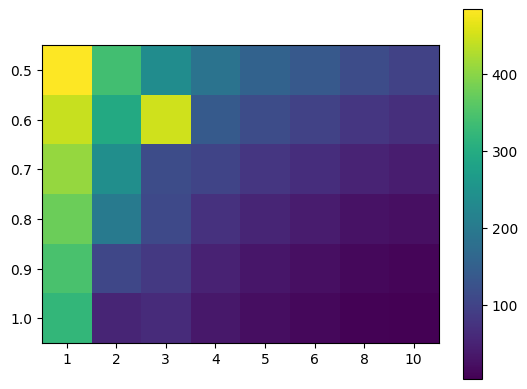

In [66]:
# Create a custom colormap that shows NaN values in red

data = all_c2[4, :, :, 2]
cmap = plt.cm.viridis.copy()
cmap.set_bad('red')

plt.imshow(data, cmap=cmap)
plt.colorbar()

# make x axis the drafts
plt.xticks(range(len(drafts)), drafts)
plt.yticks(range(len(alphas)), alphas)

plt.show()

# data = all_f2[2, :, :, 3]
# cmap = plt.cm.viridis.copy()
# cmap.set_bad('red')

# plt.imshow(data, cmap=cmap)
# plt.colorbar()
# plt.xticks(range(len(drafts)), drafts)
# plt.yticks(range(len(alphas)), alphas)
# plt.show()

# data = all_f2[2, :, :, 5]
# cmap = plt.cm.viridis.copy()
# cmap.set_bad('red')

# plt.imshow(data, cmap=cmap)
# plt.colorbar()
# plt.xticks(range(len(drafts)), drafts)
# plt.yticks(range(len(alphas)), alphas)
# plt.show()

# data = all_f2[2, :, :, 6]
# cmap = plt.cm.viridis.copy()
# cmap.set_bad('red')

# plt.imshow(data, cmap=cmap)
# plt.colorbar()
# plt.xticks(range(len(drafts)), drafts)
# plt.yticks(range(len(alphas)), alphas)
# plt.show()